<a href="https://colab.research.google.com/github/seidsohaib07/Well-pressure-model-for-a-gas-kick-in-a-vertical-well/blob/main/Well_pressure_model_for_a_gas_Kick_in_a_vertical_well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Well pressure model for a gas-Kick in a vertical well while drilling 

In well drilling engineering, a "well kick" refers to an influx of formation fluid (e.g. gas, oil, or water) into a wellbore. This can occur when the hydrostatic pressure of the drilling fluid column in the wellbore is less than the pressure of the formation being drilled, causing the formation fluid to flow into the wellbore. If not controlled properly, a well kick can lead to a blowout, which is a rapid and uncontrolled release of formation fluid that can be dangerous and costly.

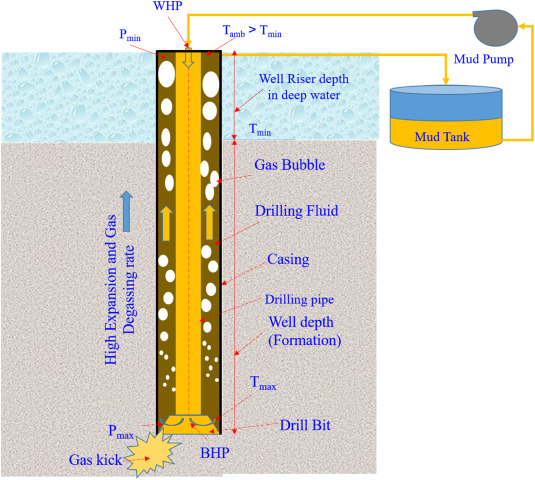

A youtube video explaining what is a well kick : [Well Kick](https://https://www.youtube.com/watch?v=816YoGEAtM4)

A Python code that models a gas kick drilling well would simulate the flow of drilling fluid and gas in a wellbore during a drilling operation, and it would include models for the various physical processes that occur, such as fluid flow, pressure gradients, and gas expansion. The code would take as inputs parameters such as the drilling fluid properties, the formation pressure and temperature, and the wellbore geometry, and it would output variables such as the well pressure, the flow rate of gas and drilling fluid, and the pressure drop across the wellbore.

Such a code would be useful for predicting the behavior of a well during drilling operations and for optimizing the drilling process to minimize the risk of well kicks and blowouts. It could also be used to test various well control procedures and to train personnel on the proper procedures for dealing with well kicks.

The code idea is taken from the explanation,documents and Matlab files was provided by Kjell Kåre Fjelde , Professor in drilling and well technology Stavanger Universitet.

This code will be updated from time to time to be more robust

The code is devided into five parts (functions)  : 

The first code related to the variation of liquid density with pressure. The function roliq takes in a liquid pressure value and calculates the density of the liquid at that pressure. It uses the difference between the input pressure and the atmospheric pressure, divided by 1000*1000, added to the density at surface conditions (1000 kg/m3 or g/l) to calculate the density.

In [ ]:
import numpy as np

In [ ]:
def roliq(pliq : float, p_atm = 100000, d_sc = 1000.0):
    '''
    This function defines a simple liquid density model that takes in a pressure value (in pascals)
    Returns the density of the liquid at that pressure. 
    The atmospheric pressure is set at 100,000 pascals (1 bar) and the density at surface conditions is set at 1000 kg/m3 or g/l. 
    The density is calculated as the difference between the input pressure and the atmospheric pressure, 
    divided by 1000*1000, added to the density at surface conditions. 
    The function also includes a check to ensure that the returned density is not less than 1000 (to avoid unphysical densities) 
    and sets the density to 1000 if the calculated density is less than this value.
    '''
    rhol = d_sc + (pliq-p_atm)/(1000*1000)
     
    #For numerical robustness.
    if rhol<1000:       #The following statement is included to avoid unphysical densitities.
        rhol = 1000     #if the numerical method guesses too low pressures.
    
    return rhol

the next code is  related to the variation of gas density with pressure. The function rogas takes in a gas pressure value and calculates the density of the gas at that pressure. It uses the pressure value divided by 100000.0 to calculate the density.

In [ ]:
def rogas(pgas : float):
    '''
    A very simple gas density model. Temp is neglected. 
    '''
    
    rhog = pgas / 100000.0

    #For numerical robustness.
    if rhog < 1:      #The following statement is included to avoid unphysical densitities.
        rhog = 1      #if the numerical method guesses too low pressures.
    
    return rhog

Next, a function called "dpfric",  calculates the frictional pressure drop for a two-phase flow in a pipe is introduced. The function takes in the following parameters:


vl: Liquid velocity

vg: Gas velocity

el: Liquid fraction

eg: Gas fraction

pressure: Pressure

do: Outer diameter of the pipe

di: Inner diameter of the pipe

viscl: Viscosity of the liquid

viscg: Viscosity of the gas


The function first calculates the mixture density (romix), mixture viscosity (viscmix), and mixture velocity (vmix) using the given inputs. It then calculates the Reynolds number (re) based on the mixture properties and pipe dimensions.

Next, the code uses the calculated Reynolds number to determine the friction factor (fricfactor) and then uses that value to calculate the friction loss gradient (friclossgrad) in Pascal per meter.

Finally, the function returns vl, do, di, and re as output.

In [ ]:
def dpfric(
        vl:float,
        vg:float,
        el:float,
        eg:float,
        pressure:float,
        do:float,
        di:float,
        viscl:float,
        viscg:float
        ):

    rhol = roliq(pressure)
    rhog = rogas(pressure)
    romix = rhol * el + rhog * eg
    viscmix = viscl * el + viscg * eg
    vmix = vg * eg + vl * el

    #Calculate mix reynolds number

    re = romix * vmix * (do - di) / viscmix

    if (re >= 3000):
        fricfactor = 0.052 * re ^ (-0.19)
    elif ((re < 3000) and (re > 2000)):
        f1 = 24 / re
        f2 = 0.052 * re ^ (-0.19)
        xint = (re - 2000) / 1000.0
        fricfactor = (1.0 - xint) * f1 + xint * f2

    else
        fricfactor = 24 / re

    # fricfactor
    # calculate friction loss gradient(Pa / m)
    friclossgrad = 2 * fricfactor * romix * vmix * abs(vmix) / (do - di)

return  vl, do, di, re

The code of wellpressure  simulates the pressure at different points in a gas and liquid well. The function takes in various inputs such as an initial pressure guess, gas and liquid flow rates, measurement depth, number of points for the simulation, and properties of the well such as outer and inner diameter. It also calculates the pressure at each point using the inputs given and uses the Darcy-Weisbach equation to calculate the frictional pressure gradient and the hydrostatic pressure gradient.

Inside the function, there are various calculations that initialize some variables, including boxlength, flowarea, k, s, liqmassratesurf, liqmassratebhp, gasmassratesurfinj, and gasmassratebhpinj.

The function then proceeds to calculate the liquid and gas flow rates at different depths and calculates the pressure gradient at each point using the Darcy-Weisbach equation. The final output of the function is the final pressure at the last point of the simulation, which is assigned to the variable Pout.

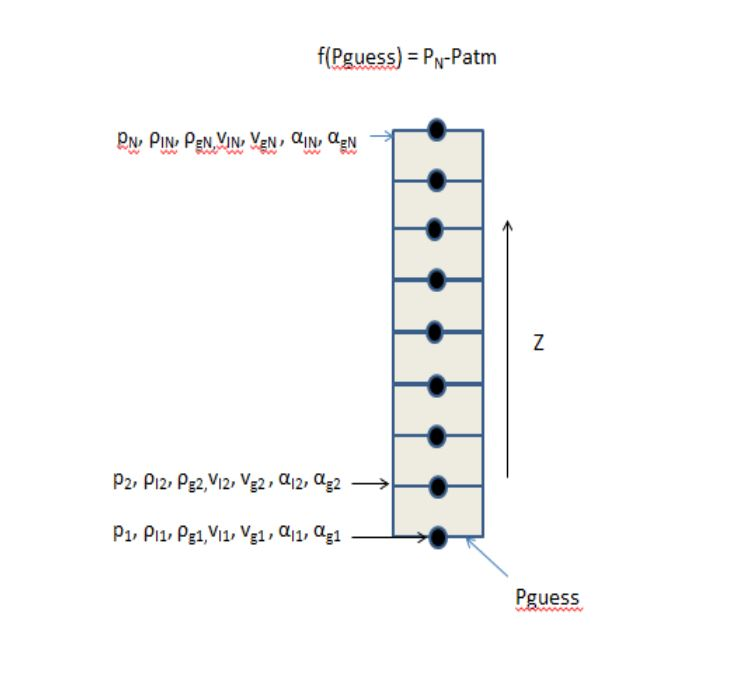

Image source : Compendium Course PET510 UIS ( Kjell Kåre Fjelde) 

In [ ]:
def wellpressure(
    pbotguess: float,
    gasrate: float,
    liquidrate: float,
    welldepth: float,
    nopoints: int,
    do: float,
    di: float,
    viscl = 0.001,
    viscg = 0.00001,
    prodinx = 0):

    '''
    This function appears to be a simulation of well pressure for a gas and liquid well. 
    The function takes in various inputs such as initial pressure guess, gas and liquid flow rates, 
    measurement depth, number of points for the simulation, and properties of the well such as outer and inner diameter. 
    It also calculates the pressure at each point using the inputs given and uses the Darcy-Weisbach equation 
    to calculate the frictional pressure gradient and the hydrostatic pressure gradient. 
    The final output of the function is the final pressure at the last point of the simulation.
    '''
    
    boxlength = welldepth/nopoints
    flowarea = (3.14/4)*(do**2-di**2)
    k = 1.2 
    s = 0.55
    g = 9.81
    
    liqmassratesurf = liquidrate*roliq(100000.0) 
    liqmassratebhp  = liqmassratesurf            
    gasmassratesurfinj = gasrate*rogas(100000.0) 
    gasmassratebhpinj  = gasmassratesurfinj      

    gasvolratesurface = prodinx*(20000000-pbotguess) 
    
    if gasvolratesurface <0:
        gasvolratesurface = 0
    
    gasmassratebhproduction  = gasvolratesurface*rogas(100000.0)
    gasmassratebhp = gasmassratebhpinj+gasmassratebhproduction

    vl = np.zeros(nopoints)              
    vg = np.zeros(nopoints)              
    vgs = np.zeros(nopoints)             
    vls = np.zeros(nopoints)             
    eg = np.zeros(nopoints)              
    el = np.zeros(nopoints)              
    p = np.zeros(nopoints)               
    fricgrad = np.zeros(nopoints-1)      
    hydgrad = np.zeros(nopoints-1)       
    
    liquidratebhp = liqmassratebhp/roliq(pbotguess)
    gasratebhp = gasmassratebhp/rogas(pbotguess)

    vls[0] = liquidratebhp/flowarea
    vgs[0] = gasratebhp/flowarea
    vg[0] = k*(vls[0]+vgs[0])+s
    eg[0] = vgs[0]/vg[0]
    el[0] = 1-eg[0]
    vl[0] = vls[0]/el[0]
    p[0] = pbotguess
    sumfric = 0
    sumhyd = 0
    for i in range(nopoints-1):
        hydgrad[i] = (roliq(p[i])*el[i]+rogas(p[i])*eg[i])*g
        fricgrad[i] = dpfric(vl[i],vg[i],el[i],eg[i],p[i],do,di,viscl,viscg)
        p[i+1] = p[i]-hydgrad[i]*boxlength-fricgrad[i]*boxlength
        vls[i+1] =vls[i]*roliq(p[i])/roliq(p[i+1])
        vgs[i+1] =vgs[i]*rogas(p[i])/rogas(p[i+1])
        vg[i+1] = k*(vls[i+1]+vgs[i+1])+s
        eg[i+1] = vgs[i+1]/vg[i+1]
        el[i+1] = 1-eg[i+1]
        vl[i+1] = vls[i+1]/el[i+1]
        sumfric += fricgrad[i]*boxlength
        sumhyd += hydgrad[i]*boxlength
    
    Pout = p(nopoints)
    
    return Pout

The Bisection method is implemented to solve an equation of the form f(x) = 0, where f(x) is the function wellpressure with respect to the bottomhole pressure pbotguess, and nopoints, welldepth, gasrate, liquidrate, do, and di are input parameters. The goal is to find the root of the function wellpressure, i.e., the value of pbotguess that makes wellpressure(pbotguess) = 0.

The Bisection method works by iteratively halving an interval that brackets the root until the interval becomes small enough, at which point the midpoint of the interval is taken as the approximation of the root.

The function starts by setting a tolerance ftol for the function value, noit to zero (which will count the number of iterations), and xguess to an initial guess for pbotguess. It then sets the search interval to be xint centered around xguess, and evaluates wellpressure at the endpoints x1 and x2. If wellpressure has the same sign at x1 and x2, the interval is not valid, and the function returns an error code of 1 and a pbot value of 0. Otherwise, it enters a loop that continues until wellpressure at the midpoint of the interval x3 is smaller in magnitude than ftol. At each iteration, the function evaluates wellpressure at x3, updates the interval to bracket the root, and computes a new midpoint. Finally, the function returns an error code of 0 (indicating success) and the approximated value of the root, pbot.

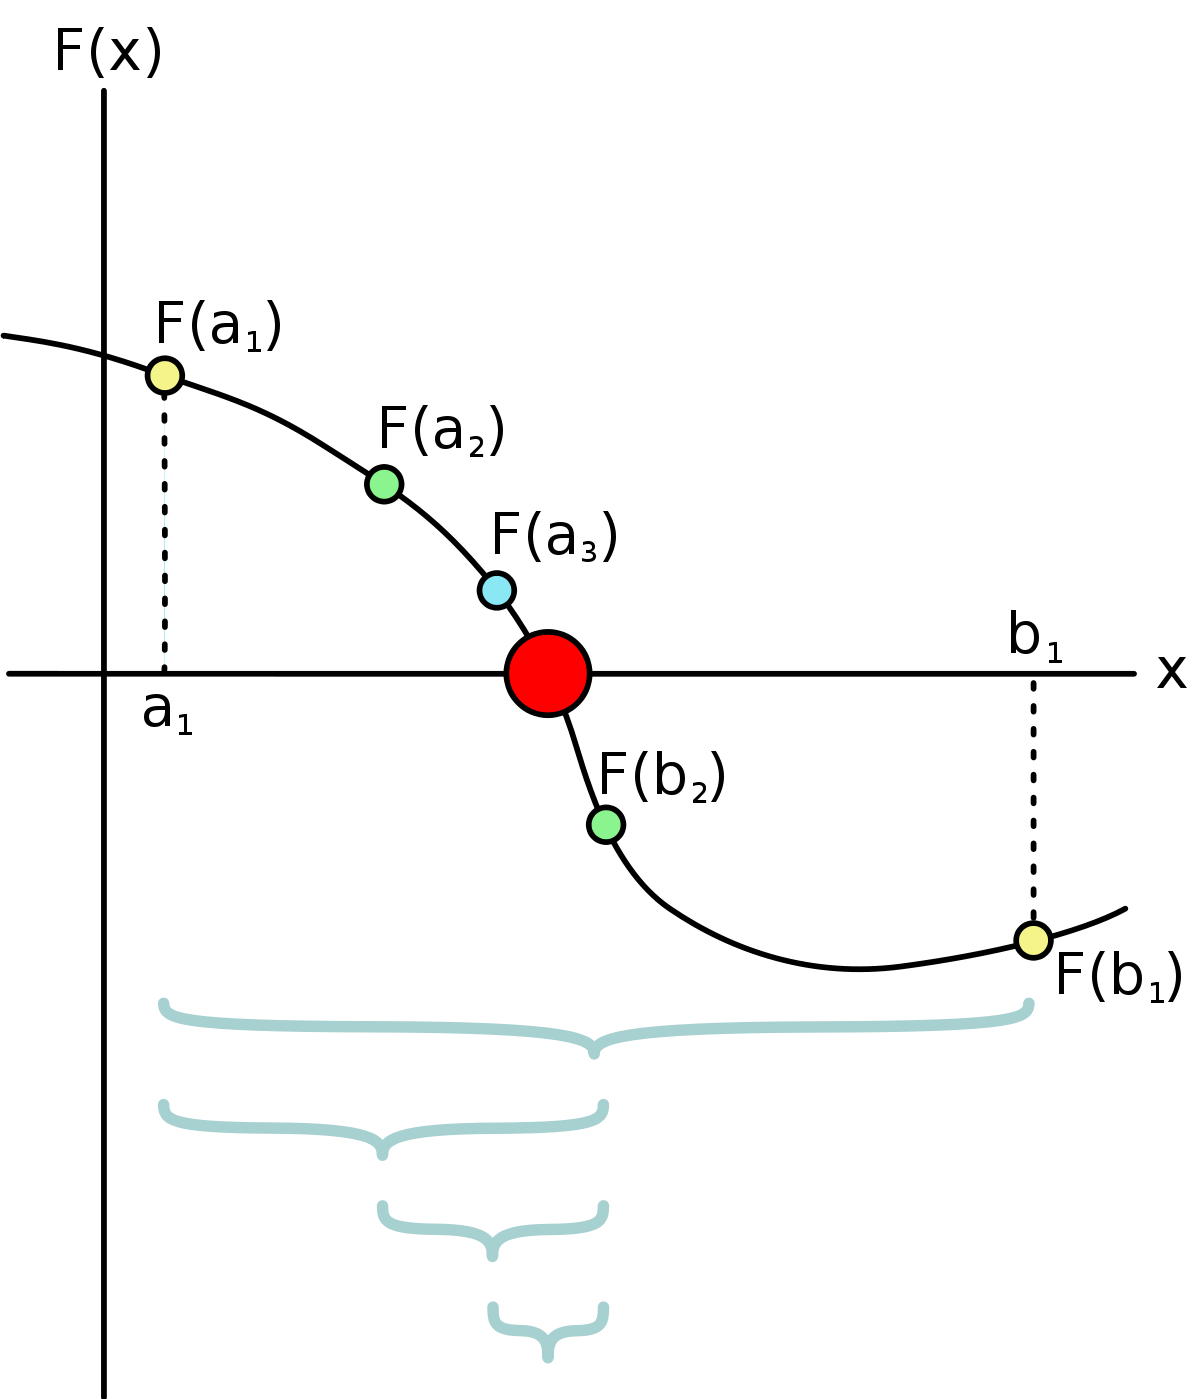

In [ ]:
#Bisection
def bhp(
    nopoints: int,
    welldepth: float,
    gasrate: float,
    liquidrate: float,
    do: float,
    di:float):
    '''
    The numerical solver implementeted here for solving the equation f(x)= 0 
    "wellpressure(pbot)= 0" is called the Method of Halving the Interval (Bisection Method).
    You will not find exact match for f(x)= 0. 
    Maybe f(x) = 0.0001. By using ftol we say that if f(x)<ftol, we are satisfied. 
    '''
    #Since our function gives results in Pascal, we say that ftol = 1000 Pa gives us a quite good answer. 
    #This is 0.01 bar and should be accurate enough!
    ftol = 1000

    #Set number of iterations to zero
    noit = 0      
    
    #Specify the search interval.
    #xguess is the pressure you guess for the bottomhole.
    #We here use hydrostic pressure of liquid in the well as our initial guess.
    #This is of course not necessarily correct because we have gas and friction effects as well. 
    #But it might be a good starting point for the iteration. 
    #Remember x is in Pa -> 1 Bar = 100 000 Pa.
    xguess = 1000*9.81*welldepth  
    xint = 1000*9.81*welldepth
    x1 = xguess-xint/2.0
    x2 = xguess+xint/2.0
    f1 = wellpressure(pbotguess= x1, gasrate=gasrate, liquidrate=liquidrate, welldepth=welldepth, nopoints=nopoints, do=do, di=di)
    f2 = wellpressure(pbotguess= x2, gasrate=gasrate, liquidrate=liquidrate, welldepth=welldepth, nopoints=nopoints, do=do, di=di)
    
    #First include a check on whether f1xf2<0. If not you must adjust your initial search intervall. 
    #If error is 1 and zero pbot, then you must adjust the intervall here.
    if f1*f2>=0:
        error = 1
        pbot = 0
    else:
        x3 = (x1+x2)/2.0
        f3 = wellpressure(pbotguess= x3, gasrate=gasrate, liquidrate=liquidrate, welldepth=welldepth, nopoints=nopoints, do=do, di=di)
        while f3>ftol or f3<-ftol:
            noit += 1
            if f3*f1 < 0:
                x2 = x3
            else:
                x1 = x3
            x3 = (x1+x2)/2.0
            f3 = wellpressure(pbotguess= x3, gasrate=gasrate, liquidrate=liquidrate, welldepth=welldepth, nopoints=nopoints, do=do, di=di)
            f1 = wellpressure(pbotguess= x1, gasrate=gasrate, liquidrate=liquidrate, welldepth=welldepth, nopoints=nopoints, do=do, di=di)
        error = 0
        pbot = x3
    return error, pbot